In [1]:
# Importing essential libraries to visualize and preprocess data, train, test and evaluate the model
import torch
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import torchvision
from sklearn.preprocessing import LabelEncoder, StandardScaler
import skimage
import imageio
import seaborn as sns
from PIL import Image
import glob
import matplotlib.pyplot as plt
import matplotlib
import shutil
%matplotlib inline

# Determine the device (GPU or CPU) to be used by PyTorch for computations - Recommended device: GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

##### Load and analyze the metadata 

In [2]:
# Reading the metadata file('full_df.csv') into a pandas DataFrame(metadata)
metadata = pd.read_csv('Dataset/full_df.csv')

In [3]:
# Viewing a few rows of metadata DataFrame to inspect the contents
metadata.head()

ID  Patient Age Patient Sex Left-Fundus Right-Fundus  \
0   0           69      Female  0_left.jpg  0_right.jpg   
1   1           57        Male  1_left.jpg  1_right.jpg   
2   2           42        Male  2_left.jpg  2_right.jpg   
3   4           53        Male  4_left.jpg  4_right.jpg   
4   5           50      Female  5_left.jpg  5_right.jpg   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   
3                        macular epiretinal membrane   
4             moderate non proliferative retinopathy   

                Right-Diagnostic Keywords  N  D  G  C  A  H  M  O  \
0                           normal fundus  0  0  0  1  0  0  0  0   
1                           normal fundus  1  0  0  0  0  0  0  0   
2  moderate non proliferative retinopathy  0  1  0  0  0  0  0  1   
3       mild nonproliferative retinopathy  0  1  0  0  0  0  0  1   
4  moderate non proliferative retinopathy  0  1  0  0  0  0  0  0   

                                            filepath labels  \
0  ../input/ocular-disease-recognition-odir5k/ODI...  ['N']   
1  ../input/ocular-disease-recognition-odir5k/ODI...  ['N']   
2  ../input/ocular-disease-recognition-odir5k/ODI...  ['D']   
3  ../input/ocular-disease-recognition-odir5k/ODI...  ['D']   
4  ../input/ocular-disease-recognition-odir5k/ODI...  ['D']   

                     target     filename  
0  [1, 0, 0, 0, 0, 0, 0, 0]  0_right.jpg  
1  [1, 0, 0, 0, 0, 0, 0, 0]  1_right.jpg  
2  [0, 1, 0, 0, 0, 0, 0, 0]  2_right.jpg  
3  [0, 1, 0, 0, 0, 0, 0, 0]  4_right.jpg  
4  [0, 1, 0, 0, 0, 0, 0, 0]  5_right.jpg

In [4]:
# Determining the number of rows and columns in the metadata DataFrame
metadata.shape

(6392, 19)

In [5]:
# Checking for missing values and validating column data types
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 14  O       

##### Data Preprocessing

Metadata has labels and target column which contain only single label data but we need multi-label data for mulitple diagnosis for an input image. Hence labels and target columns are dropped and then recreated using keywords. The labels for left fundus images are created using Left-Diagnostic Keywords column and the labels for right fundus images are created using Right-Diagnostic Keywords column.

Also, filepath, filename and 'N', 'D', 'G', 'C', 'A', 'H', 'M', 'O' columns are dropped and recreated again.

In [6]:
# Dropping specified columns as they correspond to single Ocular disease identification
# We will recreate these columns by identifying multiple eye conditions listed in 'Left-Diagnostic Keywords' and 'Right-Diagnostic Keywords' columns
metadata.drop(columns = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O', 'filepath', 'labels', 'target', 'filename'], axis=1, inplace= True)

In [7]:
# metadata DataFrame after removing the above mentioned columns
metadata.head()

ID  Patient Age Patient Sex Left-Fundus Right-Fundus  \
0   0           69      Female  0_left.jpg  0_right.jpg   
1   1           57        Male  1_left.jpg  1_right.jpg   
2   2           42        Male  2_left.jpg  2_right.jpg   
3   4           53        Male  4_left.jpg  4_right.jpg   
4   5           50      Female  5_left.jpg  5_right.jpg   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   
3                        macular epiretinal membrane   
4             moderate non proliferative retinopathy   

                Right-Diagnostic Keywords  
0                           normal fundus  
1                           normal fundus  
2  moderate non proliferative retinopathy  
3       mild nonproliferative retinopathy  
4  moderate non proliferative retinopathy

In [8]:
#Identifying annotations that correspond to 7 primary Ocular diseases(that we wish to identify) and other diseases/abnormalities

# Initialize sets to store all unique labels and unique labels corresponding to other diseases/abnormalities
unique_labels = set()
unique_others = set()
count = 0

# Iterate through each entry in the "Left-Diagnostic Keywords" column of the metadata DataFrame
for i in metadata["Left-Diagnostic Keywords"]:
    labels = i.split('，') # Split the annotations by comma
#     print(labels)
    for label in labels:
#         print(label)
        unique_labels.add(label) # Add each unique label to the set of unique labels

# Define the keywords present in annotations that correspond to the 7 primary Eye conditions
annotations = ['normal','cataract', 'proliferative retinopathy', 'diabetic retinopathy', 'glaucoma', 'hypertensive', 'myopia', 'macular degeneration']

# Iterate through the unique labels and identify those that do not correspond to the primary annotations
for label in unique_labels:
    if not any(annotation in label for annotation in annotations):
        unique_others.add(label)

print(f"Total number of annotations in metadata = {len(unique_labels)}")
print(f"Number of annotations that correpond to other diseases/abnormalities = {len(unique_others)}")
print(f"Number of annotations that correspond to 7 primary Eye conditions = {len(unique_labels) - len(unique_others)}")


Total number of annotations in metadata = 75
Number of annotations that correpond to other diseases/abnormalities = 55
Number of annotations that correspond to 7 primary Eye conditions = 20


In [9]:
# Function to check if a specific term is present in the given text
# Passed arguments - term,text
# term - The term to search for in the text
# text - The text to search within
# The function will return 1 if the term is present in the text, 0 otherwise

def has_condn(term,text):
    if term in text:
        return 1
    else:
        return 0

In [10]:
# Function to check if a specific term is present in the given text and exclude certain terms identified to be associated with different conditions
# Passed arguments - term,text
# term - The term to search for in the text
# text - The text to search within
# The function will return 1 if the term is present in the text and specific terms are not present, 0 otherwise
def has_condns(term, text):
    if term in text and 'chorioretinopathy' not in text and 'hypertensive' not in text:
        return 1
    else:
        return 0

In [11]:
# Initialize new columns with default value 0
metadata["N"]= 0
metadata["C"]= 0
metadata["D"]= 0
metadata["G"]= 0
metadata["H"]= 0
metadata["M"]= 0
metadata["A"]= 0

# Loop through each row in the first half of DataFrame
for l in range(0, 3194):
    # Check if specific keywords are present in the 'Right-Diagnostic Keywords' column and update corresponding columns
    metadata.loc[l, "N"] = has_condn("normal fundus", metadata.loc[l, "Right-Diagnostic Keywords"])
    metadata.loc[l, "C"] = has_condn("cataract", metadata.loc[l, "Right-Diagnostic Keywords"])
    metadata.loc[l, "D"] = has_condns("retinopathy", metadata.loc[l, "Right-Diagnostic Keywords"])
    metadata.loc[l, "G"] = has_condn("glaucoma", metadata.loc[l, "Right-Diagnostic Keywords"])
    metadata.loc[l, "H"] = has_condn("hypertensive", metadata.loc[l, "Right-Diagnostic Keywords"])
    metadata.loc[l, "M"] = has_condn("myopia", metadata.loc[l, "Right-Diagnostic Keywords"])
    metadata.loc[l, "A"] = has_condn("macular degeneration", metadata.loc[l, "Right-Diagnostic Keywords"])
    

In [12]:
# Loop through each row in the second half of the DataFrame
for j in range(3194, 6392):
    # Check if specific keywords are present in the 'Left-Diagnostic Keywords' column and update corresponding columns
    metadata.loc[j, "N"] = has_condn("normal fundus", metadata.loc[j, "Left-Diagnostic Keywords"])
    metadata.loc[j, "C"] = has_condn("cataract", metadata.loc[j, "Left-Diagnostic Keywords"])
    metadata.loc[j, "D"] = has_condns("retinopathy", metadata.loc[j, "Left-Diagnostic Keywords"])
    metadata.loc[j, "G"] = has_condn("glaucoma", metadata.loc[j, "Left-Diagnostic Keywords"])
    metadata.loc[j, "H"] = has_condn("hypertensive", metadata.loc[j, "Left-Diagnostic Keywords"])
    metadata.loc[j, "M"] = has_condn("myopia", metadata.loc[j, "Left-Diagnostic Keywords"])
    metadata.loc[j, "A"] = has_condn("macular degeneration", metadata.loc[j, "Left-Diagnostic Keywords"])

In [13]:
# Listing keywords present in annotations that correspond to the 7 primary Eye conditions (primary annotations)
annotations = ['normal fundus','cataract', 'proliferative retinopathy', 'diabetic retinopathy', 'glaucoma', 'hypertensive', 'myopia', 'macular degeneration', 'lens dust']

# Create a new column 'O' to indicate other abnormalities
metadata["O"]= 0

# Iterate over each key-value pair in the 'Right-Diagnostic Keywords' column
for key, values in metadata["Right-Diagnostic Keywords"].items():
    # Split the values by comma to extract individual labels
    labels = values.split('，')
    
     # Check each label to see if it matches any of the primary annotations
    for label in labels:
        # If the label does not match any of the annotations, set 'O' to 1
        if not any(annotation in label for annotation in annotations):
            # Check if the key falls within the range of the first half of the DataFrame
            if key>=0 and key<3194:
                metadata.loc[key, "O"] = 1
        

In [14]:
# Iterate over each key-value pair in the 'Left-Diagnostic Keywords' column
for l_key, l_values in metadata["Left-Diagnostic Keywords"].items():
    # Split the values by comma to extract individual labels
    l_labels = l_values.split('，')
    
    # Check each label to see if it matches any of the primary annotations
    for label in l_labels:
        # If the label does not match any of the annotations, set 'O' to 1
        if not any(annotation in label for annotation in annotations):
            # Check if the key falls in the second half of the DataFrame
            if l_key>=3194:
                metadata.loc[l_key, "O"] = 1

In [15]:
# Viewing the updated metadata 
metadata.head()

ID  Patient Age Patient Sex Left-Fundus Right-Fundus  \
0   0           69      Female  0_left.jpg  0_right.jpg   
1   1           57        Male  1_left.jpg  1_right.jpg   
2   2           42        Male  2_left.jpg  2_right.jpg   
3   4           53        Male  4_left.jpg  4_right.jpg   
4   5           50      Female  5_left.jpg  5_right.jpg   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   
3                        macular epiretinal membrane   
4             moderate non proliferative retinopathy   

                Right-Diagnostic Keywords  N  C  D  G  H  M  A  O  
0                           normal fundus  1  0  0  0  0  0  0  0  
1                           normal fundus  1  0  0  0  0  0  0  0  
2  moderate non proliferative retinopathy  0  0  1  0  0  0  0  0  
3       mild nonproliferative retinopathy  0  0  1  0  0  0  0  0  
4  moderate non proliferative retinopathy  0  0  1  0  0  0  0  0

In [16]:
# Define a function to process multiple rows in the metadata DataFrame and list the diagnoses, label and target
metadata["diagnoses"] = ""
metadata["label"] = ""
metadata["targets"] = ""

def process_path(index, row):
     # Initialize empty lists to store diagnoses, labels, and targets
    diagnoses = []
    label = []
    targets = []

    # Check if 'N' column is equal to 1 (indicating normal fundus)
    if (row['N']==1):
        diagnoses.append("normal")
        label.append('N')
        targets.append(1)
    else: targets.append(0)

    # Check if 'D' column is equal to 1 (indicating diabetes)
    if (row['D']==1):
        diagnoses.append("diabetes")
        label.append('D')
        targets.append(1)
    else: targets.append(0)

    # Check if 'G' column is equal to 1 (indicating glaucoma)
    if (row['G']==1):
        diagnoses.append("glaucoma")
        label.append('G')
        targets.append(1)
    else: targets.append(0)

    # Check if 'C' column is equal to 1 (indicating cataract)
    if (row['C']==1):
        diagnoses.append("cataract") 
        label.append('C')
        targets.append(1)
    else: targets.append(0)

    # Check if 'A' column is equal to 1 (indicating age related macular degeneration)
    if (row['A']==1):
        diagnoses.append("age related macular degeneration")
        label.append('A')
        targets.append(1)
    else: targets.append(0)

    # Check if 'H' column is equal to 1 (indicating hypertension)
    if (row['H']==1):
        diagnoses.append("hypertension") 
        label.append('H')
        targets.append(1)
    else: targets.append(0)

    # Check if 'M' column is equal to 1 (indicating pathological myopia)
    if (row['M']==1):
        diagnoses.append("pathological myopia")
        label.append('M')
        targets.append(1)
    else: targets.append(0)

    # Check if 'O' column is equal to 1 (indicating other diseases/abnormalities)
    if (row['O']==1):
        diagnoses.append("other diseases/abnormalities")
        label.append('O')
        targets.append(1)
    else: targets.append(0)

    # Update the 'diagnoses', 'label', and 'targets' columns for the current row
    row["diagnoses"] = diagnoses
    row["label"] = label
    row["targets"] = targets

    # Update the metadata DataFrame with the modified row
    metadata.loc[index] = row

# Apply the 'process_path' function to each row in the metadata DataFrame and store the results
updated_paths = [process_path(index, row) for index, row in metadata.iterrows()]

In [17]:
# Viewing the updated metadata 
metadata.head()

ID  Patient Age Patient Sex Left-Fundus Right-Fundus  \
0   0           69      Female  0_left.jpg  0_right.jpg   
1   1           57        Male  1_left.jpg  1_right.jpg   
2   2           42        Male  2_left.jpg  2_right.jpg   
3   4           53        Male  4_left.jpg  4_right.jpg   
4   5           50      Female  5_left.jpg  5_right.jpg   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   
3                        macular epiretinal membrane   
4             moderate non proliferative retinopathy   

                Right-Diagnostic Keywords  N  C  D  G  H  M  A  O   diagnoses  \
0                           normal fundus  1  0  0  0  0  0  0  0    [normal]   
1                           normal fundus  1  0  0  0  0  0  0  0    [normal]   
2  moderate non proliferative retinopathy  0  0  1  0  0  0  0  0  [diabetes]   
3       mild nonproliferative retinopathy  0  0  1  0  0  0  0  0  [diabetes]   
4  moderate non proliferative retinopathy  0  0  1  0  0  0  0  0  [diabetes]   

  label                   targets  
0   [N]  [1, 0, 0, 0, 0, 0, 0, 0]  
1   [N]  [1, 0, 0, 0, 0, 0, 0, 0]  
2   [D]  [0, 1, 0, 0, 0, 0, 0, 0]  
3   [D]  [0, 1, 0, 0, 0, 0, 0, 0]  
4   [D]  [0, 1, 0, 0, 0, 0, 0, 0]

In [18]:
# Initialize a new column 'filename' in the metadata DataFrame to store associated fundus image names
metadata["filename"] = ""

# Iterate over each row in the metadata DataFrame
for index, row in metadata.iterrows():
    # Retrieve the row for the current index in the metadata DataFrame
    cell_value = metadata.loc[index]

    # Determine whether to use 'Left-Fundus' or 'Right-Fundus' based on the index
    if index>=3194:
        sample = cell_value['Left-Fundus']                
    if index<3194:
        sample = cell_value['Right-Fundus']

    # Update the 'filename' column with the appropriate fundus image name
    metadata.loc[index, 'filename'] = sample
    

In [19]:
# Create a new column 'filepath' in the metadata DataFrame to store file paths
metadata["filepath"] = ""

# Get the current working directory path
cwd_path = os.getcwd()

# Define the folder containing preprocessed images
folder = 'Dataset/preprocessed_images'
# Construct the source path by joining the current working directory with the folder name
src_path = os.path.join(cwd_path, folder)

# Iterate over each row in the metadata DataFrame
for index, row in metadata.iterrows():
    # Retrieve the row for the current index
    cell_value = metadata.loc[index]

    # Get the filename from the current row
    sample = cell_value['filename']

    # Construct the full file path by joining the source path with the filename
    path = os.path.join(src_path, sample)

    # Store the file path in the 'filepath' column of the metadata DataFrame for the current index
    metadata.loc[index, 'filepath'] = path


In [20]:
# Viewing the updated metadata 
metadata.head()

ID  Patient Age Patient Sex Left-Fundus Right-Fundus  \
0   0           69      Female  0_left.jpg  0_right.jpg   
1   1           57        Male  1_left.jpg  1_right.jpg   
2   2           42        Male  2_left.jpg  2_right.jpg   
3   4           53        Male  4_left.jpg  4_right.jpg   
4   5           50      Female  5_left.jpg  5_right.jpg   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   
3                        macular epiretinal membrane   
4             moderate non proliferative retinopathy   

                Right-Diagnostic Keywords  N  C  D  G  H  M  A  O   diagnoses  \
0                           normal fundus  1  0  0  0  0  0  0  0    [normal]   
1                           normal fundus  1  0  0  0  0  0  0  0    [normal]   
2  moderate non proliferative retinopathy  0  0  1  0  0  0  0  0  [diabetes]   
3       mild nonproliferative retinopathy  0  0  1  0  0  0  0  0  [diabetes]   
4  moderate non proliferative retinopathy  0  0  1  0  0  0  0  0  [diabetes]   

  label                   targets     filename  \
0   [N]  [1, 0, 0, 0, 0, 0, 0, 0]  0_right.jpg   
1   [N]  [1, 0, 0, 0, 0, 0, 0, 0]  1_right.jpg   
2   [D]  [0, 1, 0, 0, 0, 0, 0, 0]  2_right.jpg   
3   [D]  [0, 1, 0, 0, 0, 0, 0, 0]  4_right.jpg   
4   [D]  [0, 1, 0, 0, 0, 0, 0, 0]  5_right.jpg   

                                            filepath  
0  /usr/cs/grad/master/pnandiko/CHM/Project/CHMPr...  
1  /usr/cs/grad/master/pnandiko/CHM/Project/CHMPr...  
2  /usr/cs/grad/master/pnandiko/CHM/Project/CHMPr...  
3  /usr/cs/grad/master/pnandiko/CHM/Project/CHMPr...  
4  /usr/cs/grad/master/pnandiko/CHM/Project/CHMPr...

### Visualizing Data Distribution 

In [21]:
#Plotting column counts to gain insights into data
# Initialize an empty list to store column names for plotting
plot_columns = []

# Iterate over each column in the metadata DataFrame
for column in metadata.columns:
    # Add 'Patient Age', 'Patient Sex' to list of columns for plotting
    if column in ['Patient Age','Patient Sex']:
        plot_columns.append(column)
plot_columns

['Patient Age', 'Patient Sex']

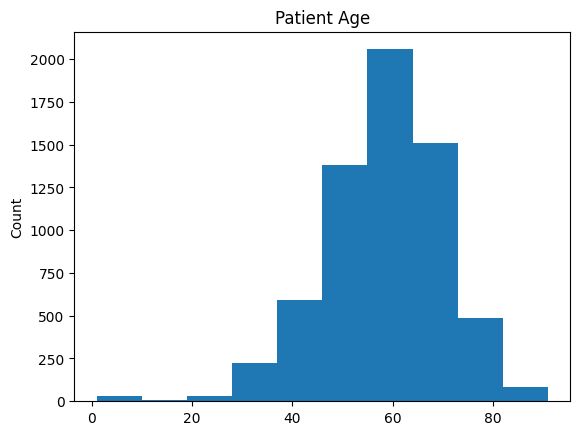

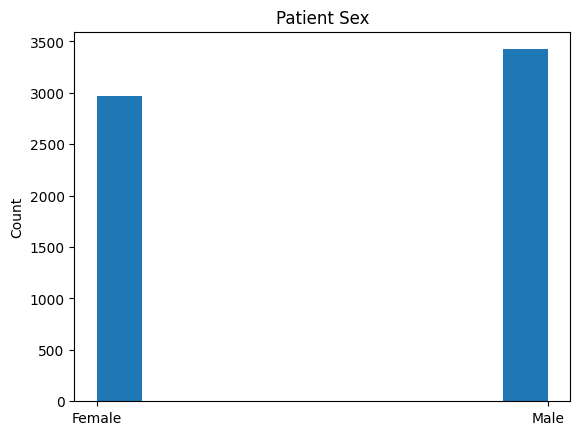

In [22]:
# Iterate through each column in the plot_columns list
for column in plot_columns:
    # Extract the values of the current column
    x = metadata[column]
    x = x.values
    # Set the title of the plot as the column name
    plt.title(column)
    # Set the label for the y-axis
    plt.ylabel('Count')
    # Create a histogram of the values in the column
    plt.hist(x)
    plt.show()

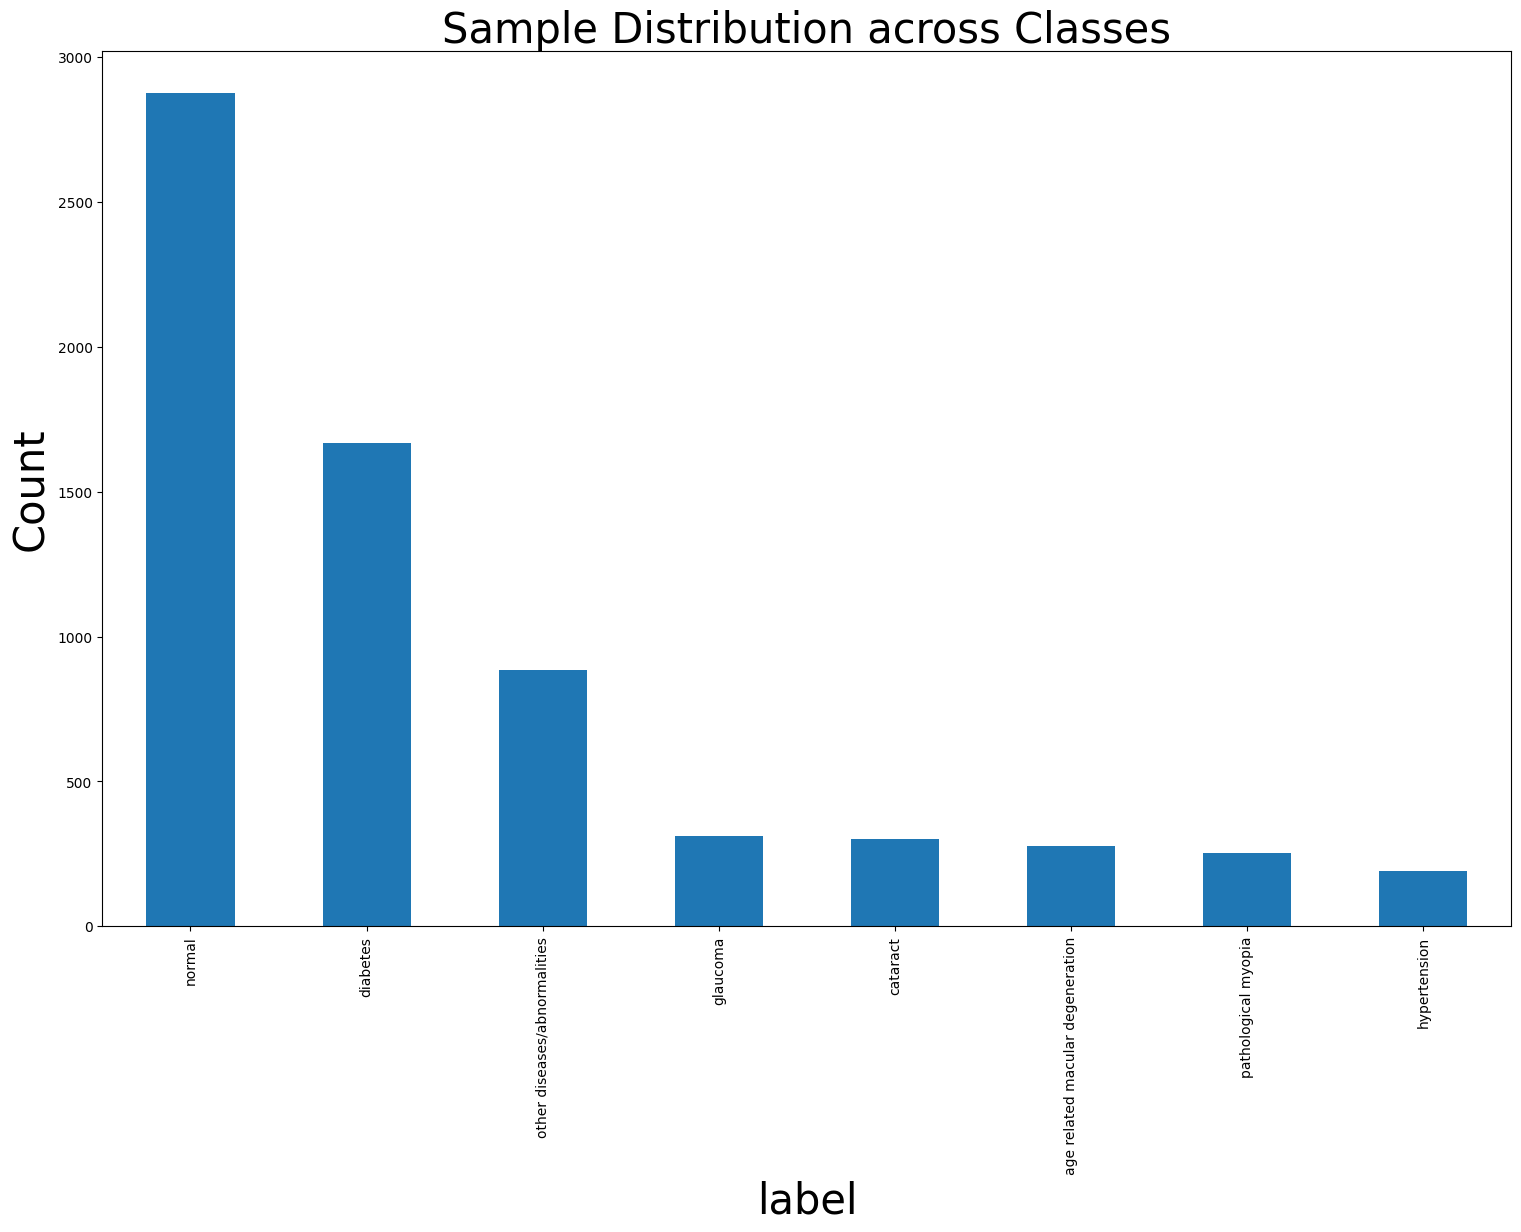

In [23]:
# Getting a sense of what the distribution of diagnoses column looks like

# Create a new figure for the plot with a specified size
fig = plt.figure(figsize=(40,25))

# Add a subplot to the figure
ax1 = fig.add_subplot(221)

# Expanding metadata such that each row corresponds to a single value of the specified column
exploded_metadata = metadata.explode('diagnoses')

# Plot the value counts of the expanded 'diagnoses' column as a bar chart on the subplot
exploded_metadata['diagnoses'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count', size=30)
ax1.set_xlabel('label', size=30)
ax1.set_title('Sample Distribution across Classes', size = 30)
plt.xticks(rotation=90)
plt.show()

In [24]:
# Expanding metadata such that each row corresponds to a single value of the specified column
exploded_metadata = metadata.explode('label')
# Count the occurrences of each value in the 'label' column
count = exploded_metadata['label'].value_counts()
print(count)

label
N    2874
D    1666
O     883
G     313
C     301
A     279
M     253
H     192
Name: count, dtype: int64



##### Determing class weights using Median Frequency Balancing
- Median frequency balancing helps address class imbalance issues in classification tasks where certain classes may be underrepresented in the dataset compared to others. 
- For each class label, the frequency is calculated as the ratio of the number of occurrences of that label to the total number of samples in the dataset
- Median frequency represents the central tendency of the class frequencies
- Class weights are computed by dividing the median frequency by the frequency of each class label

In [25]:
# Defining the list of class labels
label = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

# Function to estimate class weights based on median frequency balancing
def estimate_weights(label):
    class_weights = {}
    weights_aligned = np.zeros_like(label, dtype=np.float64)
    
    # Expanding metadata such that each row corresponds to a single value of the specified column
    exploded_metadata = metadata.explode('label')

    #Counting the occurances of each class label
    class_count = exploded_metadata['label'].value_counts()

    #Counting the total number of samples in the dataset
    total_count = metadata.shape[0]

    #Calculating the frequency of each class label (each class occurance/total occuranes of all classes)
    class_frequency = {}
    for key, cls in class_count.items():
        class_frequency[key] = (cls/total_count)

    #Calculatin median of class frequencies
    class_frequencies = np.array(list(class_frequency.values()), dtype=np.float64)
    median_frequency = np.median(class_frequencies)

    #Calculating weights of each class (median frequency/frequency of each class)
    for lbl in class_frequency:
        class_weights[lbl] = median_frequency/ class_frequency[lbl]
    
    # Aligning the weights with the order of class labels
    for i, v in enumerate(label):
        if v in class_weights:
            weights_aligned[i] = class_weights[v]
    return weights_aligned

# Estimate the class weights 
cls_weights = estimate_weights(label)                                  

# Print the class weights                                  
for i in range(len(cls_weights)):
    print(label[i],":", cls_weights[i])
    
     

N : 0.10681976339596382
D : 0.1842737094837935
G : 0.9808306709265175
C : 1.0199335548172759
A : 1.1003584229390682
H : 1.5989583333333333
M : 1.2134387351778657
O : 0.347678369195923


In [26]:
# Computing the weights of individual classes and converting them to tensors
class_weights = estimate_weights(label)
class_weights = torch.FloatTensor(class_weights)

In [27]:
#Defining a custom dataset to facilitate data preparation and transformation to make data suitable for loading into memory (data loading)
from torch.utils.data import DataLoader, Dataset
from skimage import io
from PIL import Image
from torchvision import transforms

#Custom dataset for Ocular Disease Recognition
class OcularDiseaseRecognition(Dataset):

    # Passed arguments to function = X, y, root_dir, dataset
    # X - is a series containing image filenames
    # y - is a series containing labels
    # root_dir (str) - is the path to directory containing the images 
    # dataset (str) - indicates whether the dataset is for training or testing

    def __init__(self, X, y, root_dir, dataset):
        
        self.labels_frame = X
        self.root_dir = root_dir
        self.label = y
        self.dataset = dataset

        # Defining transformations for training and testing data
        self.train_transform = transforms.Compose([
                                                 transforms.Resize((224, 224)),
                                                 transforms.ToTensor(),
                                                 transforms.RandomHorizontalFlip(),
                                                 transforms.RandomRotation(degrees=60),
                                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])

        
        self.test_transform = transforms.Compose([
                                                 transforms.Resize((224, 224)),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])
            
    # Function to return the number of samples in the dataset
    def __len__(self):
        return len(self.labels_frame)
    
    # Function to retrieve an item from the dataset
    def __getitem__(self, idx):
        """Retrieve an item from the dataset."""
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Construct the complete file path for the image by joining the root directory path and the filename
        img_name = os.path.join(self.root_dir,
                                self.labels_frame.iloc[idx])
        image = Image.open(img_name)
        # Retrieve the label for the current sample from the label series
        target = self.label.iloc[idx]
        # Convert the label to a NumPy array for compatibility with PyTorch tensors
        target = np.array(target)
        # Convert the label to a PyTorch tensor
        target = torch.tensor(target)
        
        # Apply appropriate transformation based on the dataset type (train or test)
        if self.dataset == 'train':
            image = self.train_transform(image)
        elif self.dataset == 'test':
            image = self.test_transform(image)
            
        sample = {'image': image, 'labels': target}

        return sample
    


In [28]:
# Initializing an empty lists to store file paths and targets
Xt = []
yt = []
features = None # Initialize features
labels = None # Initialize labels
# Initializing an empty list to store labels
label = []

In [29]:
Xt = metadata['filepath'] # Extracting file paths from the 'filepath' column of the metadata DataFrame
yt = metadata['targets'] # Extracting targets from the 'targets' column of the metadata DataFrame

In [30]:
# Extracting a sample of file paths and targets from the metadata DataFrame
Xt_sample = Xt.iloc[:25]
yt_sample = yt.iloc[:25]

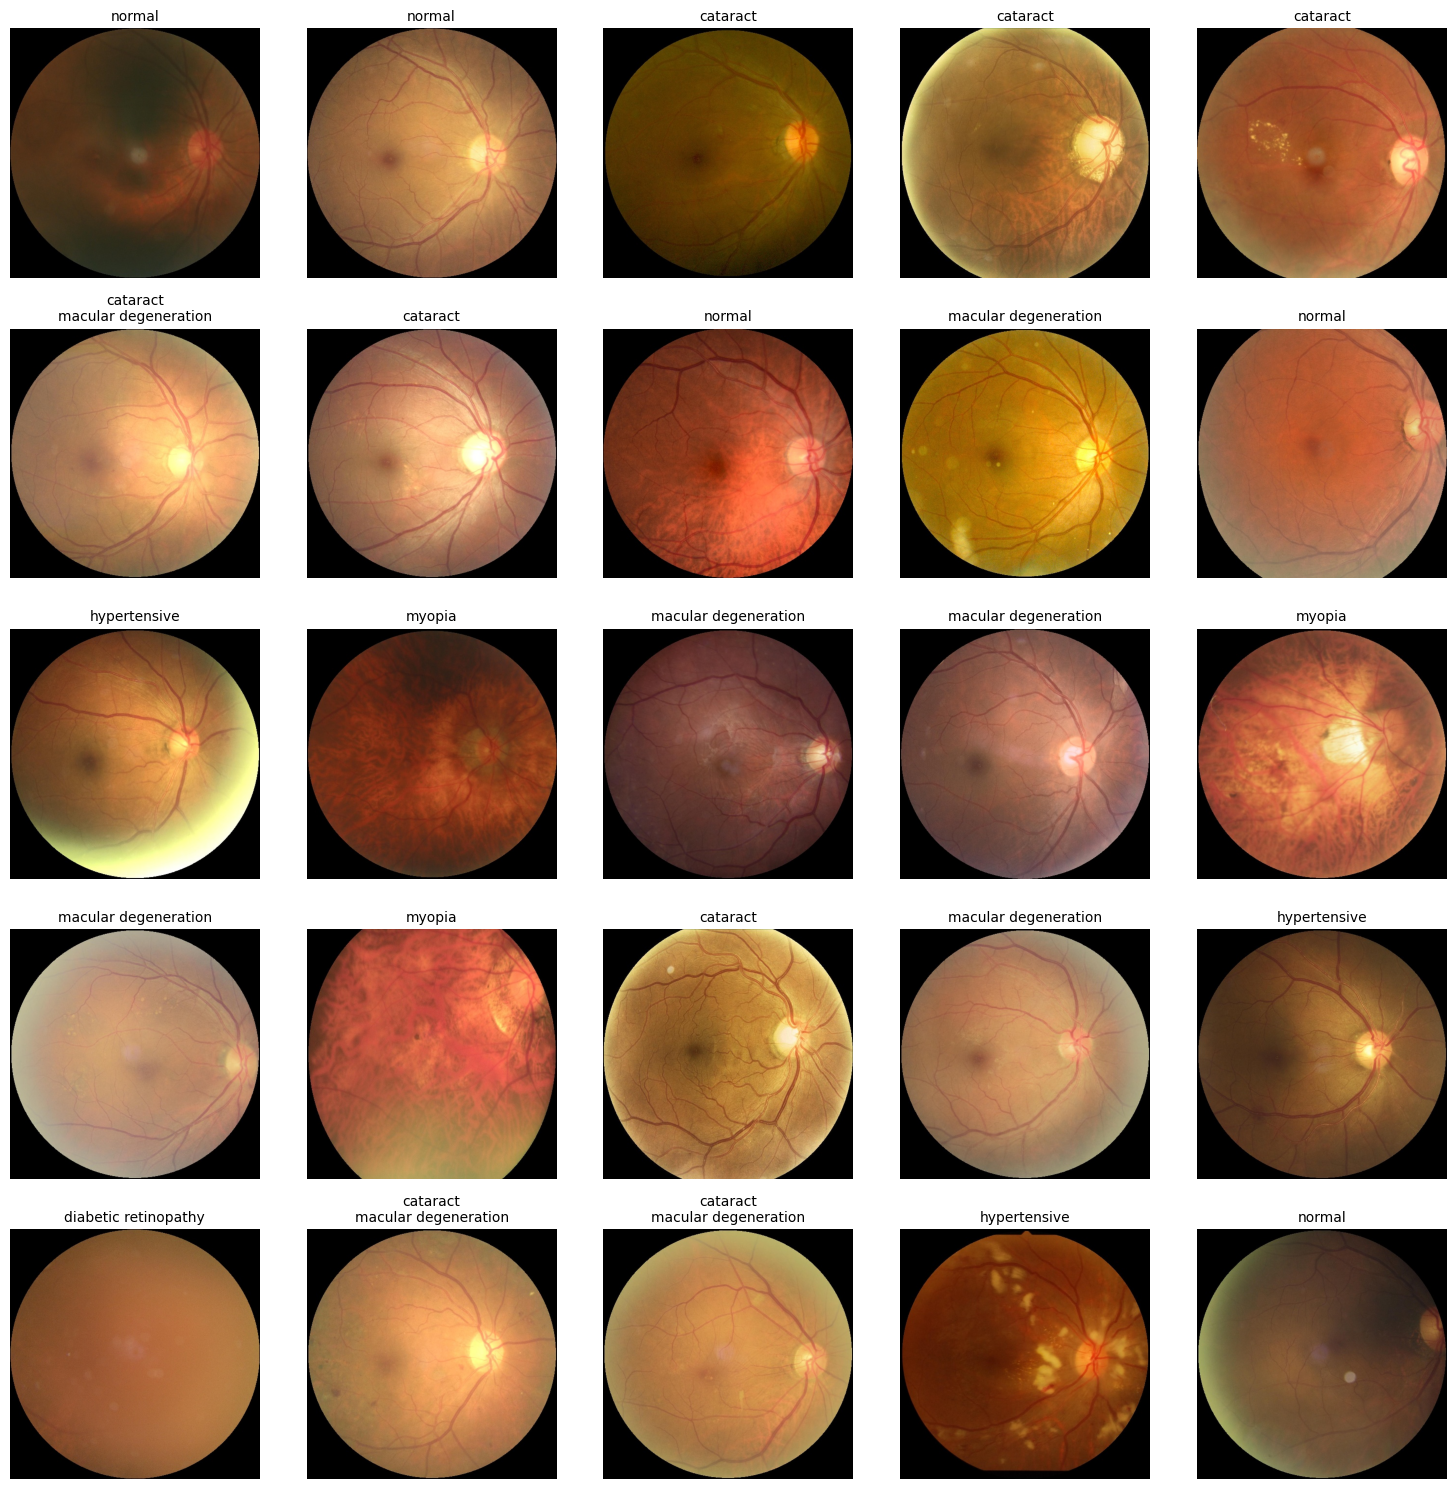

In [31]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Create a subplot grid for displaying images and their corresponding labels
f, ax = plt.subplots(5, 5, figsize=(15,15))
# Defining the list of labels 
annotations = ['normal','cataract', 'proliferative retinopathy', 'diabetic retinopathy', 'glaucoma', 'hypertensive', 'myopia', 'macular degeneration']

# Iterate through each image path and its corresponding labels in the sample
for i, img_path in enumerate(Xt_sample):
    # Construct the complete path to the image
    image_path = os.path.join(path, img_path)
    # Open the image using PIL
    img = Image.open(image_path)
    # Display the image in the corresponding subplot
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis('off') # Turn off axis to make the plot cleaner
    
    # Get the indices of target labels that are present (i.e., where the target value is 1)
    label_indices = [j for j, label in enumerate(yt_sample[i]) if label == 1]
    # Map the target indices to their corresponding labels
    labels = [annotations[j] for j in label_indices]
    # Set the title of the subplot with the corresponding labels
    ax[i//5, i%5].set_title('\n'.join(labels), fontsize=10)  

# Adjust the layout to make the plot neater
plt.tight_layout()  

# Display the plot
plt.show()


##### Train, Test and Validation Split
We split the entire dataset into 3 parts:

- Train: 70%
- Test: 15%
- Validation: 15%

In [32]:
# 70 % training, 15% validating, 15% testing
from sklearn.model_selection import train_test_split

# Splitting the dataset into training and testing sets
# 70% training, 30% testing
X_train, X_test, y_train, y_test = train_test_split(Xt, yt, test_size=0.3, shuffle=True) 

# Further splitting the testing set into validation and testing sets
# 50% validation, 50% testing
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=True)  

In [33]:
# Resetting the index of the training data to ensure it starts from 0
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# Resetting the index of the validation data to ensure it starts from 0
X_valid = X_valid.reset_index(drop=True)
y_valid = y_valid.reset_index(drop=True)

# Resetting the index of the testing data to ensure it starts from 0
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [34]:
# Printing the size of the training data, testing data and validation data
print(f"Train data size= {len(X_train)}")
print(f"Test data size = {len(X_valid)}")
print(f"Validation data size = {len(X_test)}")

Train data size= 4474
Test data size = 959
Validation data size = 959


In [35]:
import torch
from torchvision import transforms

# Creating the training dataset
train_set = OcularDiseaseRecognition(X= X_train, y= y_train, root_dir=path, dataset='train') 

# Creating the validation dataset
valid_set = OcularDiseaseRecognition(X= X_valid, y= y_valid, root_dir=path, dataset='test')

# Creating the testing dataset
test_set = OcularDiseaseRecognition(X= X_test, y= y_test, root_dir=path, dataset='test')

In [36]:
# Retrieve a single sample from the training dataset to view its contents
train_set[1]

{'image': tensor([[[-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
          [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
          [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
          ...,
          [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
          [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
          [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291]],
 
         [[-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
          [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
          [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
          ...,
          [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
          [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
          [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183]],
 
         [[-2.2214, -2.2214, -2.2214,  ..., -2.2214, -2.2214, -2.2214],
          [-2.2214,

In [37]:
# Generate lists of indices for the training, validation, and testing sets
# These lists will be used by RandomSampler to sample batches of data during training, validation, and testing
train_idx = list(range(len(X_train))) 
valid_idx = list(range(len(X_valid))) 
test_idx = list(range(len(X_test))) 

In [38]:
# Define RandomSamplers for obtaining training, testing and validation batches
# These samplers will be used to sample batches of data during training, validation, and testing.
from torch.utils.data.sampler import SubsetRandomSampler
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler  = SubsetRandomSampler(test_idx)

In [39]:
# Prepare data loaders by combining dataset and sampler
batch_size = 50 # Define batch size for training data
validation_batch_size = 10 # Define batch size for validation data
test_batch_size = 10 # Define batch size for testing data

# Create data loader for training set
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
    sampler=train_sampler)

# Create data loader for validation set
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, 
    sampler=valid_sampler)

# Create data loader for testing set
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, 
    sampler=test_sampler)

In [40]:
# Calculate and view the number of batches in the training data loader
num_train_batches = len(train_loader)
num_train_batches

90

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

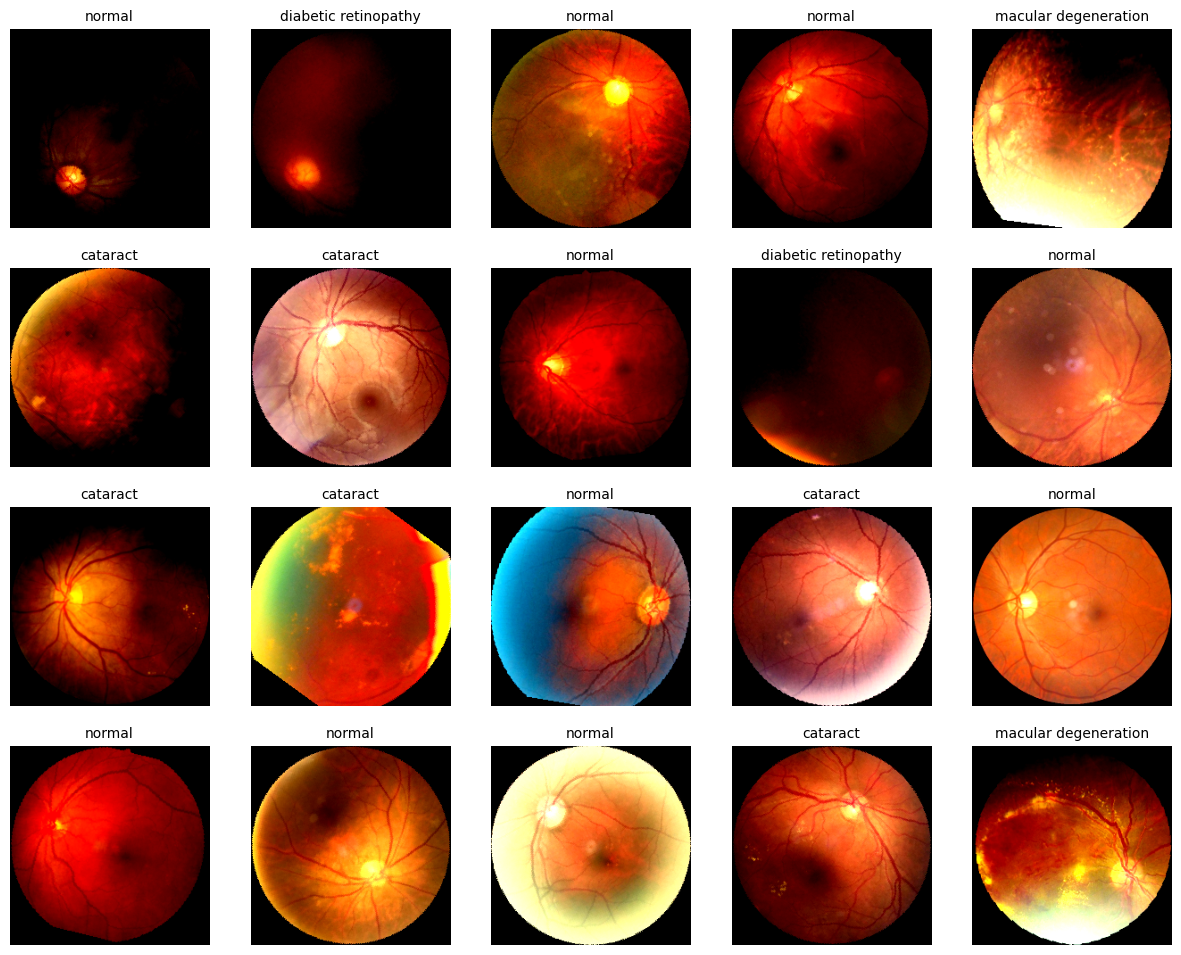

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Define the classes
classes = ['normal', 'diabetes', 'glaucoma', 'cataract', 'age related macular degeneration', 'hypertension', 'pathological myopia', 'other diseases/abnormalities']

# Function to show an image with multiple labels
def imshow(img, labels):
    # Denormalize the image (if it was normalized)
    img = img / 2 + 0.5
    npimg = img.numpy()
    label_ind = [j for j, label in enumerate(labels) if label == 1]
    labels = [annotations[j] for j in label_ind]
    plt.title('\n '.join(labels), fontsize =10)  # Display all corresponding labels
    plt.imshow(img.permute(1, 2, 0))  # Assuming img is a tensor
    plt.axis('off')

# Get some random training images
dataiter = iter(train_loader)
sample = next(dataiter)

# Plot the images in the batch, along with the corresponding labels
plt.figure(figsize=(15, 15))
batch_size = 20
for idx in np.arange(batch_size):
    plt.subplot(5, 5, idx + 1)
    imshow(sample['image'][idx], sample['labels'][idx].tolist())  # Convert label tensor to list

plt.show()


In [42]:
from torch import nn
import torchvision.models as models

num_classes = len(classes)
resnet = models.resnet50(pretrained=True)

# Modify the last layer to match the number of classes
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, num_classes)

# Move the model to the appropriate device (GPU if available)
resnet = resnet.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [43]:
import torch.optim as optim

# Move the class weights tensor to the appropriate device (here GPU)
class_weights = class_weights.to(device)

# Define the loss function with class weights for binary classification (here choice of loss function is Binary Cross Entropy loss)
criterion = nn.BCEWithLogitsLoss(weight=class_weights)

# Define the optimizer for training the model (here Adam optimizer)
optimizer = optim.Adam(resnet.parameters(), lr=1e-4)

# Print the model architecture
print(resnet)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [44]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Function to calculate the number of correct predictions
def get_accuracy(predicted, labels):
    # Initialize variables to count batch length and correct predictions
    batch_len, correct= 0, 0
    # Calculate batch length
    batch_len = labels.size(0)
    # Count the number of correct predictions in the batch
    correct = (predicted == labels).all(dim=1).sum().item()
    return batch_len, correct

# Function to evaluate the model on the validation set
def evaluate(model, val_loader):
    # Initialize variables for loss, total number of samples, and total number of correct predictions
    losses= 0
    num_samples_total=0
    correct_total=0
    # Initialize lists to store predicted labels, true labels, and predicted probabilities
    predicted_labels = []
    true_labels = []
    predicted_probs = []
    # Set the model to evaluation mode
    model.eval()
    # Iterate over the validation loader
    for i, data in enumerate(valid_loader):
        # Get the inputs and labels from validation data loader
        inputs, labels = data['image'], data['labels']
        # Move inputs and labels to the appropriate device (here GPU)
        labels, inputs = labels.to(device, dtype=torch.float), inputs.to(device, dtype=torch.float)
        # Forward pass to obtain the model predictions
        out = model(inputs)
        # Apply sigmoid activation to convert raw outputs to probabilities
        predicted = torch.sigmoid(out)
        # Convert probabilities to binary predictions (0 or 1) using a threshold of 0.5
        predicted_bin = (predicted > 0.5).float()
        # Calculate the loss for the current batch
        loss = criterion(out, labels)
        # Accumulate the loss
        losses += loss.item() 
        # Get the number of samples and correct predictions for the current batch
        b_len, corr = get_accuracy(predicted_bin, labels)
        # Accumulate the total number of samples and correct predictions
        num_samples_total +=b_len
        correct_total +=corr
        # Extend the lists with predicted labels, true labels, and predicted probabilities
        predicted_labels.extend(predicted_bin.cpu().detach().numpy())
        true_labels.extend(labels.cpu().detach().numpy())
        predicted_probs.extend(predicted.cpu().detach().numpy()) 

    # Compute accuracy as the ratio of correct predictions to total samples
    accuracy = correct_total/num_samples_total
    # Compute average loss over all batches
    losses = losses/len(val_loader)
    
    # Convert true_labels and predicted_labels to numpy arrays for sklearn metrics
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    # Compute precision, recall, F1 score, and AUC using sklearn metrics
    precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=0)
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    auc = roc_auc_score(true_labels, predicted_probs, average='weighted')  
    
    return losses, accuracy, precision, recall, f1, auc


In [45]:
# Number of epochs for training (loops over the dataset)
num_epochs = 30
# Initialize lists to store training and validation metrics
accuracy = []
val_accuracy = []
losses = []
val_losses = []

# Loop over the specified number of epochs
for epoch in range(num_epochs):
    # Initialize variables to track loss and accuracy
    running_loss = 0.0
    correct_total= 0.0
    num_samples_total=0.0

    # Iterate over the train dataloader
    for i, data in enumerate(train_loader):
        # Get the inputs and labels from the train dataloader
        inputs, labels = data['image'], data['labels']
        # Move inputs and labels to the appropriate device (here GPU)
        labels, inputs = labels.to(device, dtype=torch.float), inputs.to(device, dtype=torch.float)
        # set the parameter gradients to zero
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = resnet(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate the loss
        loss.backward()   # Backward pass
        optimizer.step()  # Update the weights
        
        # Apply sigmoid activation to convert raw outputs to probabilities
        predicted = torch.sigmoid(outputs)
        # Convert probabilities to binary predictions (0 or 1) using a threshold of 0.5
        predicted_binary = (predicted > 0.5).float()
        #compute training accuracy 
        b_len, corr = get_accuracy(predicted_binary, labels)
        num_samples_total +=b_len
        correct_total +=corr
        # Accumulate the running loss
        running_loss += loss.item()

    # Compute average training loss and accuracy for the epoch
    running_loss /= len(train_loader)
    train_accuracy = correct_total/num_samples_total
     # Evaluate the model on the validation set
    val_loss, val_acc, val_precision, val_recall, val_f1, val_auc = evaluate(resnet, valid_loader)
    
    # Print training and validation metrics for the epoch
    print('Epoch: %d' %(epoch+1))
    print('Loss: %.3f  Accuracy:%.3f' %(running_loss, train_accuracy))
    print('Precision: %.3f  Recall: %.3f  F1 Score: %.3f   AUC: %.3f' % (val_precision, val_recall, val_f1, val_auc))
    print('Validation Loss: %.3f  Val Accuracy: %.3f' %(val_loss, val_acc))
    
    # Append the metrics to the corresponding lists for visualization
    losses.append(running_loss)
    val_losses.append(val_loss)
    accuracy.append(train_accuracy)
    val_accuracy.append(val_acc)

# Print a message indicating the end of training
print('Finished Training')

Epoch: 1
Loss: 0.163  Accuracy:0.257
Precision: 0.658  Recall: 0.362  F1 Score: 0.404   AUC: 0.758
Validation Loss: 0.101  Val Accuracy: 0.365
Epoch: 2
Loss: 0.128  Accuracy:0.274
Precision: 0.365  Recall: 0.320  F1 Score: 0.321   AUC: 0.713
Validation Loss: 0.115  Val Accuracy: 0.333
Epoch: 3
Loss: 0.109  Accuracy:0.357
Precision: 0.365  Recall: 0.462  F1 Score: 0.364   AUC: 0.729
Validation Loss: 0.105  Val Accuracy: 0.479
Epoch: 4
Loss: 0.110  Accuracy:0.374
Precision: 0.596  Recall: 0.417  F1 Score: 0.393   AUC: 0.764
Validation Loss: 0.102  Val Accuracy: 0.436
Epoch: 5
Loss: 0.105  Accuracy:0.379
Precision: 0.685  Recall: 0.348  F1 Score: 0.349   AUC: 0.752
Validation Loss: 0.107  Val Accuracy: 0.355
Epoch: 6
Loss: 0.101  Accuracy:0.426
Precision: 0.511  Recall: 0.478  F1 Score: 0.367   AUC: 0.765
Validation Loss: 0.104  Val Accuracy: 0.503
Epoch: 7
Loss: 0.097  Accuracy:0.442
Precision: 0.571  Recall: 0.486  F1 Score: 0.392   AUC: 0.770
Validation Loss: 0.102  Val Accuracy: 0.495

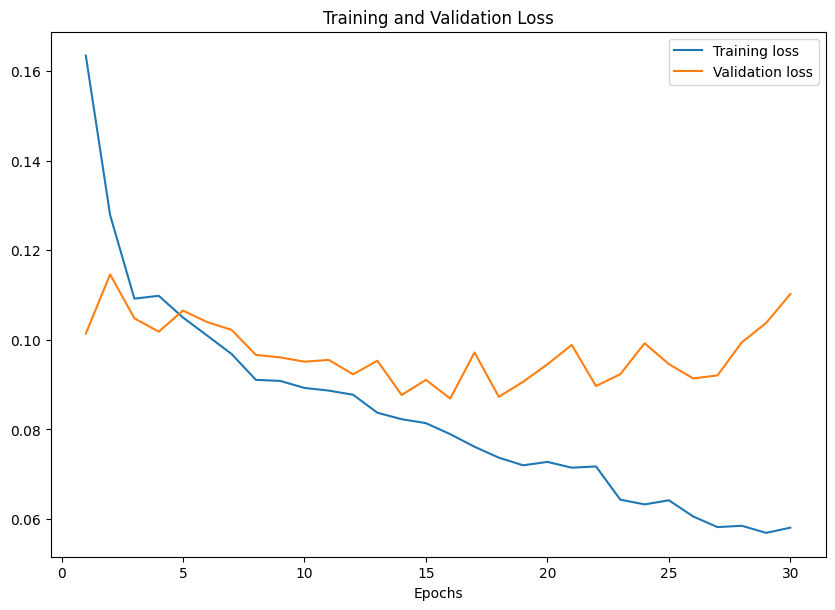

<Figure size 640x480 with 0 Axes>

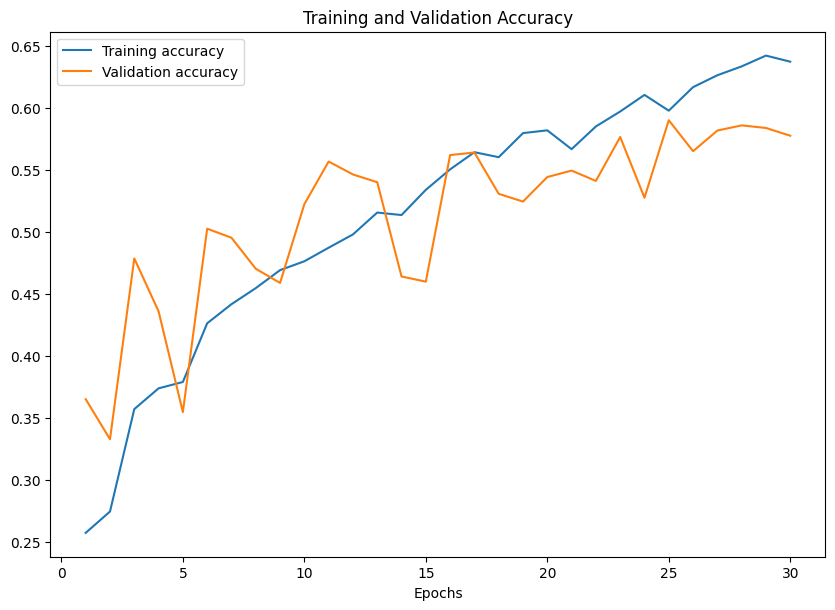

<Figure size 640x480 with 0 Axes>

In [48]:
# Define the range of epochs for plotting
epoch = range(1, num_epochs+1)

# Create a figure to plot the training and validation losses
fig = plt.figure(figsize=(10, 15))
# Subplot for training and validation losses
plt.subplot(2,1,2)

# Plot the training loss over epochs
plt.plot(epoch, losses, label='Training loss')
# Plot the validation loss over epochs
plt.plot(epoch, val_losses, label='Validation loss')

plt.title('Training and Validation Loss') # Set title for the subplot
plt.xlabel('Epochs') # Set label for x-axis
plt.legend() # Add legend to the plot
plt.figure()
plt.show() # Show the plots

# Create a new figure to plot training and validation accuracies
fig = plt.figure(figsize=(10, 15))
# Subplot for training and validation accuracies
plt.subplot(2,1,2)

# Plot the training accuracy over epochs
plt.plot(epoch, accuracy, label='Training accuracy')
# Plot the validation accuracy over epochs
plt.plot(epoch, val_accuracy, label='Validation accuracy')

plt.title('Training and Validation Accuracy') # Set title for the subplot
plt.xlabel('Epochs') # Set label for x-axis
plt.legend() # Add legend to the plot
plt.figure()
plt.show() # Show the plots

### Test the trained network on the test data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

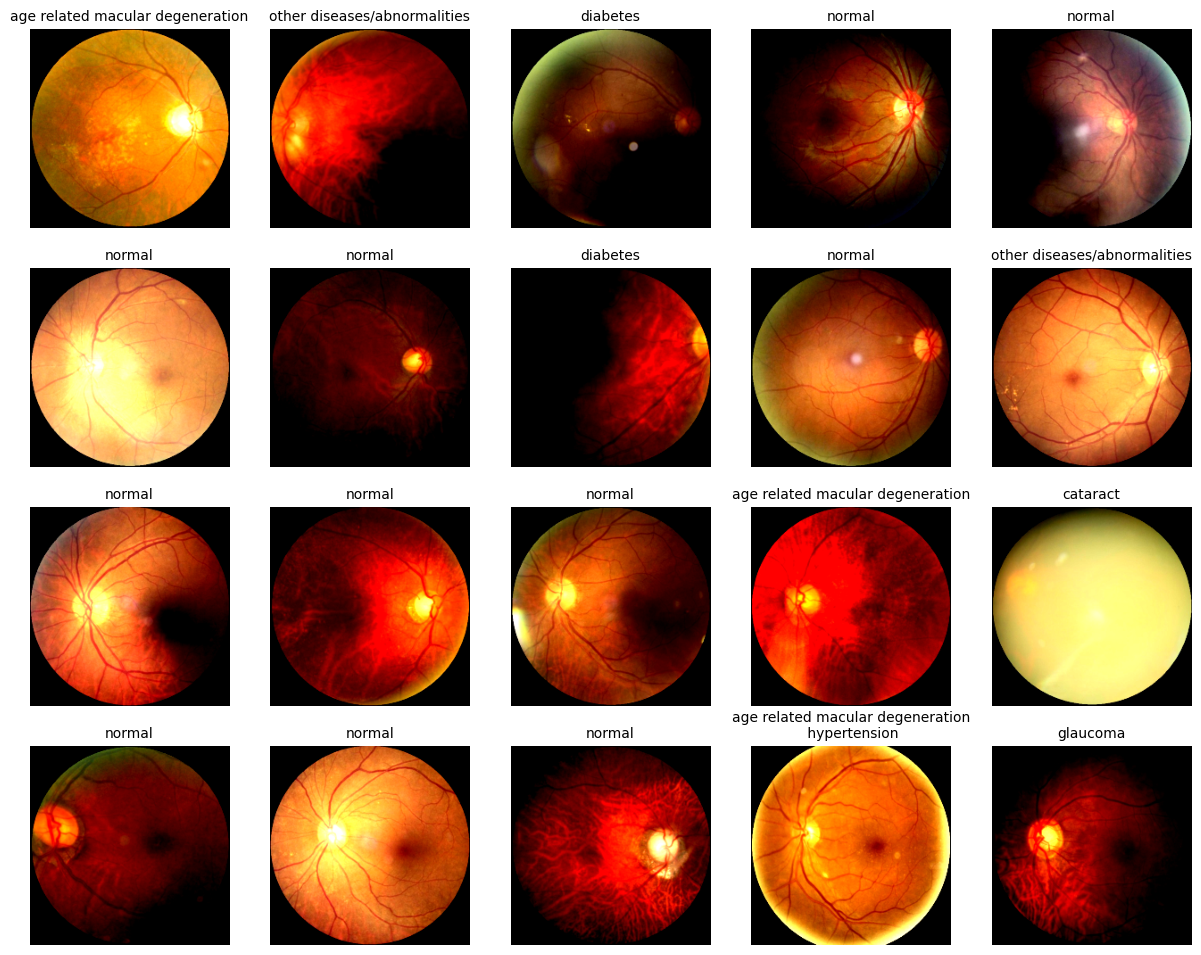

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Define the classes
classes = ['normal', 'diabetes', 'glaucoma', 'cataract', 'age related macular degeneration', 'hypertension', 'pathological myopia', 'other diseases/abnormalities']

# Function to show an image with its associated multiple labels
def imshow(img, labels):
    # Denormalize the image as it was normalized 
    img = img / 2 + 0.5
    npimg = img.numpy()

    # Extract indices of labels that are present
    label_ind = [j for j, label in enumerate(labels) if label == 1]
    # Extract labels corresponding to the indices
    labels = [classes[j] for j in label_ind]

     # Set the title with all corresponding labels
    plt.title('\n '.join(labels), fontsize =10)  # Display all corresponding labels

    # Display the image
    plt.imshow(img.permute(1, 2, 0))  
    plt.axis('off')

# Get some random test images
dataiter = iter(test_loader)
sample = next(dataiter)

# Plot the images in the batch size of 20, along with the corresponding labels
plt.figure(figsize=(15, 15))
batch_size = 20
for idx in np.arange(batch_size):
    plt.subplot(5, 5, idx + 1)
    imshow(sample['image'][idx], sample['labels'][idx].tolist())  # Convert label tensor to list

plt.show()


In [52]:
# Initialize variables to track correct predictions and total samples
correct = 0
total = 0

# Initialize lists to store predicted labels, true labels, predicted probabilities, sigmoid probabilities, and image data
predicted_labels = []
true_labels = []
predicted_probs = []
sigmoid_probs = []
image_list = []

# Set the model to evaluation mode 
resnet.eval()
# Disable gradient calculation during evaluation
with torch.no_grad():
    # Iterate over the test dataloader
    for i, data in enumerate(test_loader):
        # Get the inputs and labels from test dataloader
        inputs, labels = data['image'], data['labels']
        # Move inputs and labels to the appropriate device (here GPU)
        labels, inputs = labels.to(device, dtype=torch.float), inputs.to(device, dtype=torch.float)
        # Forward pass to get the outputs
        outputs = resnet(inputs)
        # Apply sigmoid activation to convert raw outputs to probabilities
        predicted = torch.sigmoid(outputs)
        # Convert probabilities to binary predictions (0 or 1) using a threshold of 0.5
        predicted_binary = (predicted > 0.5).float()

        # Accumulate total and correct predictions
        total += labels.size(0)
        correct += (predicted_binary == labels).all(dim=1).sum().item()

        # Extend lists with predicted labels, true labels, predicted probabilities, sigmoid probabilities, and image data
        predicted_labels.extend(predicted_binary.cpu().detach().numpy())
        true_labels.extend(labels.cpu().detach().numpy())
        sigmoid_probs.extend(predicted.cpu().detach().numpy())
        image_list.extend(inputs.cpu().detach().numpy())

# Convert lists to NumPy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)
sigmoid_probs = np.array(sigmoid_probs)
image_list = np.array(image_list)


# Calculate precision, recall, and F1 score for different averaging methods

# Micro Average
micro_precision = precision_score(true_labels, predicted_labels, average='micro')
micro_recall = recall_score(true_labels, predicted_labels, average='micro')
micro_f1 = f1_score(true_labels, predicted_labels, average='micro')

# Macro Average
macro_precision = precision_score(true_labels, predicted_labels, average='macro')
macro_recall = recall_score(true_labels, predicted_labels, average='macro')
macro_f1 = f1_score(true_labels, predicted_labels, average='macro')

#Weighted average
weighted_precision = precision_score(true_labels, predicted_labels, average='weighted')
weighted_recall = recall_score(true_labels, predicted_labels, average='weighted')
weighted_f1 = f1_score(true_labels, predicted_labels, average='weighted')

#Samples Average
samples_precision = precision_score(true_labels, predicted_labels, average='samples',zero_division=1)
samples_recall = recall_score(true_labels, predicted_labels, average='samples',zero_division=1)
samples_f1 = f1_score(true_labels, predicted_labels, average='samples',zero_division=1)

# Calculate AUC
auc = roc_auc_score(true_labels, predicted_labels, average='weighted')

# Print results
print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))
print('AUC: %.2f' % auc)

Accuracy of the network on the test images: 58 %
AUC: 0.72


In [53]:
# Define a dictionary to store evaluation metrics
results = {
    'Metric': ['Precision', 'Recall', 'F1-Score'],
    'Micro avg': [micro_precision, micro_recall, micro_f1],
    'Macro avg': [macro_precision, macro_recall, macro_f1],
    'Weighted avg': [weighted_precision, weighted_recall, weighted_f1],
    'Samples avg': [samples_precision, samples_recall, samples_f1]
}

# Convert the dictionary to a pandas DataFrame
results_df = pd.DataFrame(results)

# Set the index of the DataFrame to 'Metric'
results_df.set_index('Metric', inplace=True)

# Display the DataFrame
print(results_df)

           Micro avg  Macro avg  Weighted avg  Samples avg
Metric                                                    
Precision   0.667394   0.687528      0.673670     0.695864
Recall      0.602956   0.501695      0.602956     0.616788
F1-Score    0.633540   0.544212      0.604926     0.911540


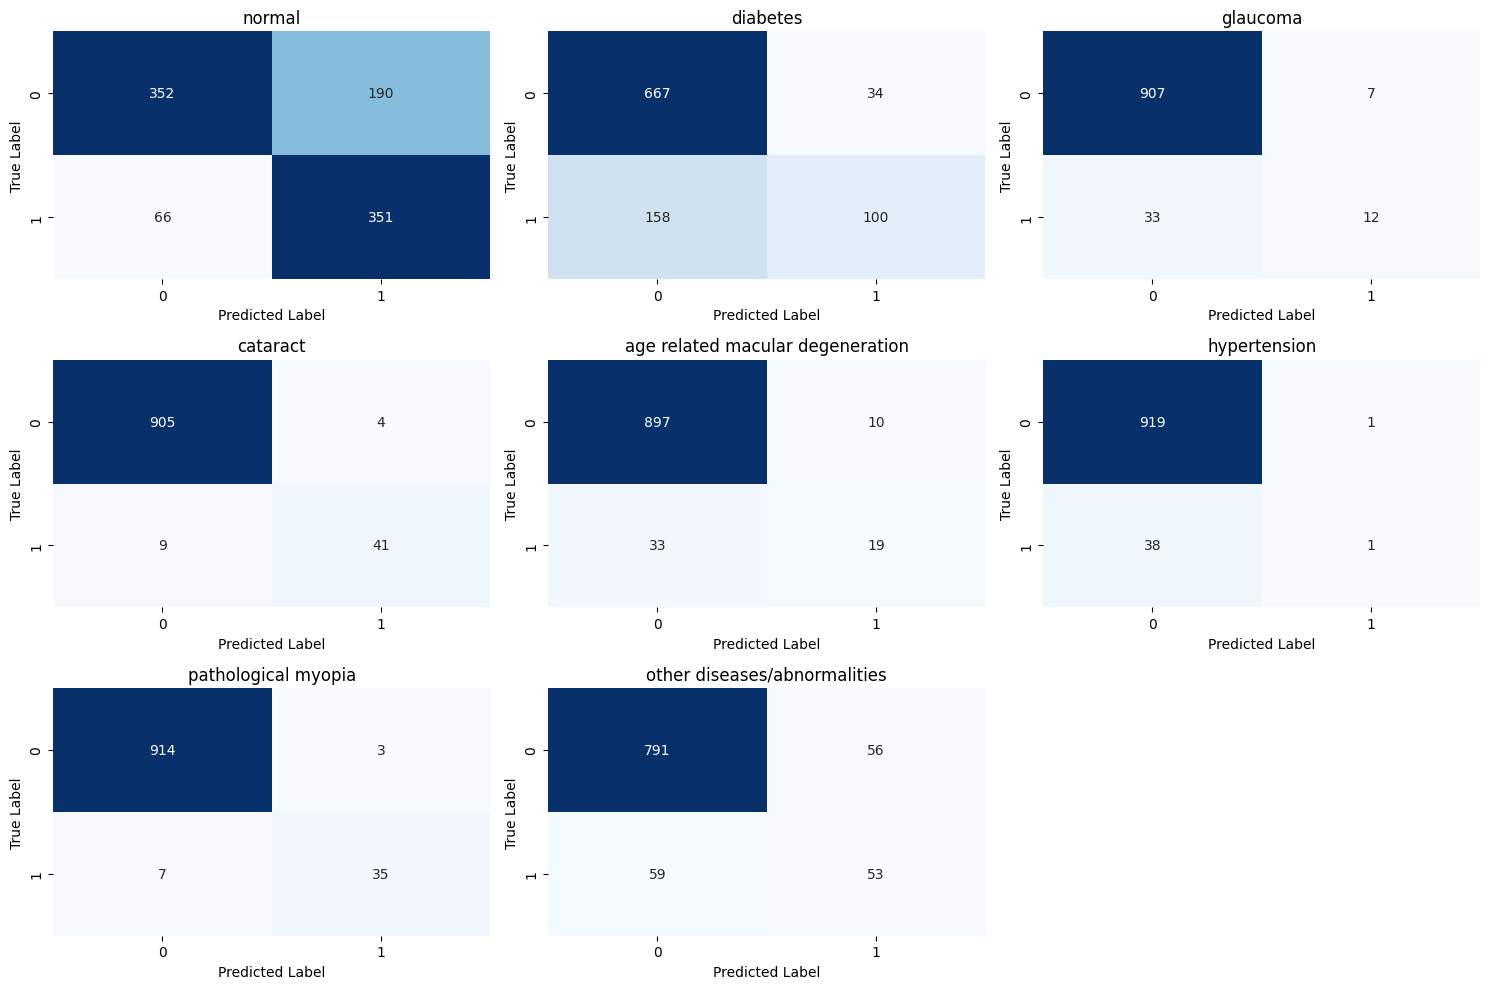

In [54]:
# Calculate confusion matrix and plot confusion matrix heatmap
from sklearn.metrics import multilabel_confusion_matrix

# Calculate the confusion matrix using multilabel_confusion_matrix function
conf_matrix = multilabel_confusion_matrix(true_labels, predicted_labels)

# Define the number of classes and class labels
num_classes = 8
classes = [ 'normal', 'diabetes', 'glaucoma', 
          'cataract','age related macular degeneration', 'hypertension', 'pathological myopia', 'other diseases/abnormalities']

# Plot the confusion matrix heatmap
plt.figure(figsize=(15, 10))
for i in range(num_classes):
    plt.subplot(3, 3, i + 1)
    sns.heatmap(conf_matrix[i], annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(classes[i])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [55]:
# Select a subset of images, predicted labels, predicted probabilities, and true labels for visualization
image_array = image_list[0:5]
label_array = predicted_labels[0:5]
probability_array = sigmoid_probs[0:5]
true_label_array = true_labels[0:5]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


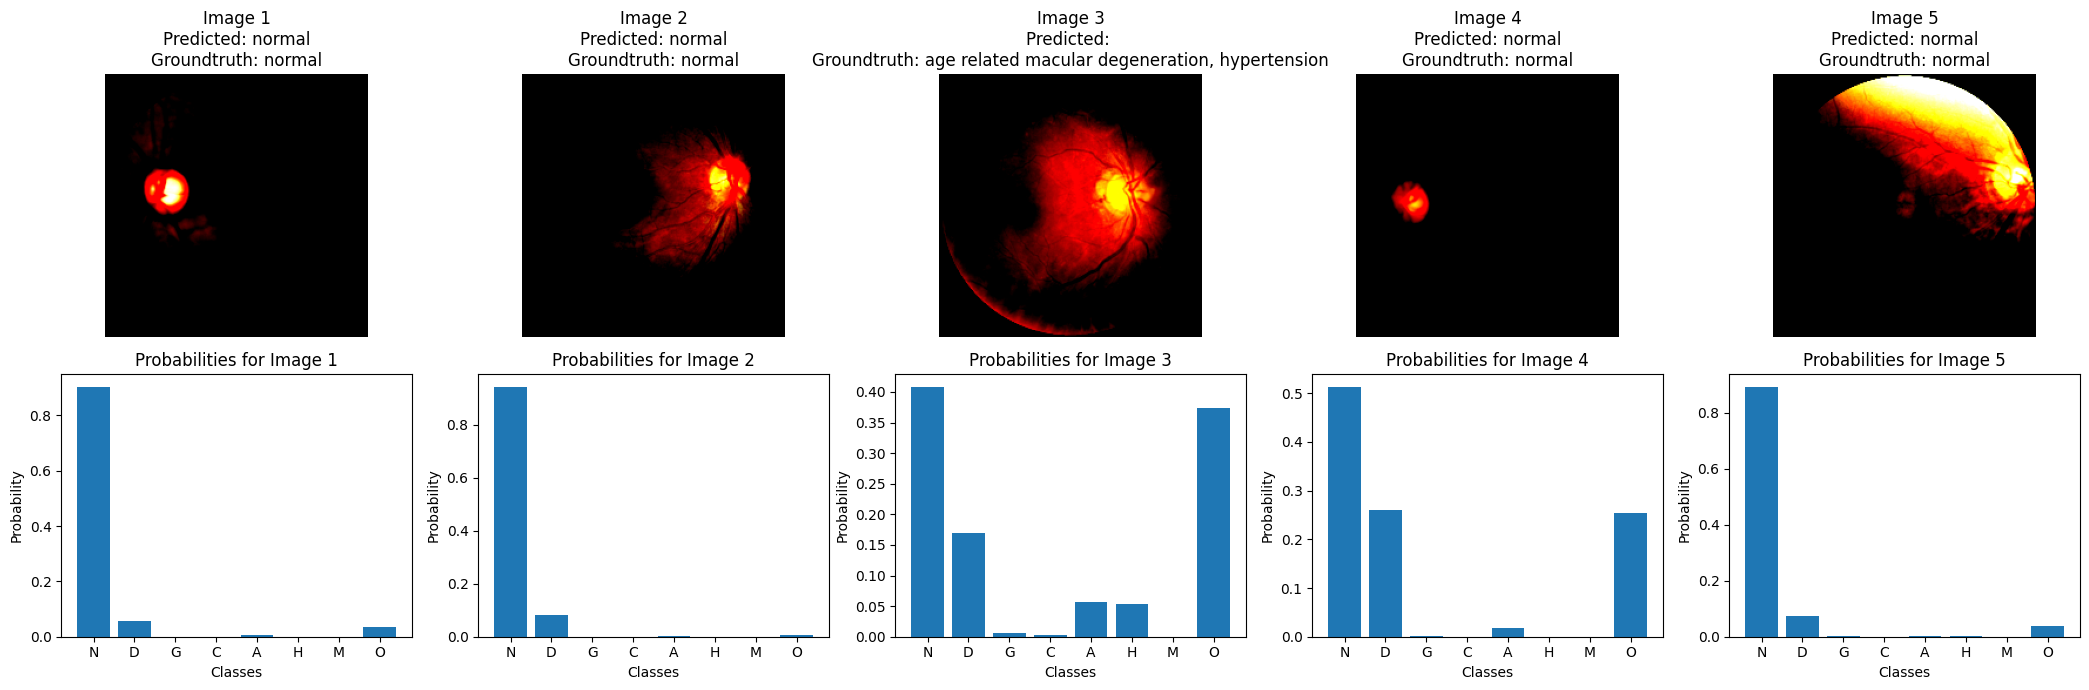

In [56]:
# Get the shape of the sigmoid probability array
num_samples, num_classes = probability_array.shape

# Creating a new figure object for plotting 
plt.figure(figsize=(21, 7))

# Iterate over each sample
for i in range(num_samples):
    # Create a subplot for each sample
    plt.subplot(2, num_samples, i+1)
    
    # Plot the image
    plt.imshow(image_array[i].transpose(1, 2, 0))  # Assuming image_array is in the shape (num_samples, channels, height, width)
    plt.axis('off')
    
    # Get the associated labels for the current sample
    associated_predicted_labels = [classes[j] for j in range(num_classes) if label_array[i][j] == 1]
    associated_true_labels = [classes[j] for j in range(num_classes) if true_label_array[i][j] == 1]
    
    # Set labels and title for each subplot
    plt.title(f'Image {i+1}\nPredicted: {", ".join(associated_predicted_labels)}\nGroundtruth: {", ".join(associated_true_labels)}')
    
    # Create a subplot for the corresponding bar plot
    plt.subplot(2, num_samples, num_samples+i+1)
    
    # Set the position of each bar
    positions = np.arange(num_classes)
    
    # Plot the bars for each sample
    plt.bar(positions, probability_array[i], width=0.8)
    
    # Set labels and title for each subplot
    plt.xlabel('Classes')
    plt.ylabel('Probability')
    plt.title(f'Probabilities for Image {i+1}')
    plt.xticks(positions, ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O'])  # Adjust xticks as needed

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()
